# Reinforcement Learning
Prof. S. Harmeling

### $n$-step return and $\lambda$-return

In this notebook, we will implement offline versions for the $n$-step return and $\lambda$-return.  
*Offline* means that the episodes are already generated and we update the value function by iterating over them.  
In this case, we can apply the forward view for the $\lambda$-return and don't need eligibility traces.

In [13]:
%load_ext autoreload
%autoreload 2

import random
import matplotlib.pyplot as plt
import numpy as np

import rl_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### $n$-step return

In the lecture the $n$-step return was defined as:
$$
g_{t:t+n} = r_{t+1} + \gamma r_{t+2} + \ldots + \gamma^{n-1} r_{t+n} + \gamma^n V(s_{t+n})
$$

In the implementation we need to check for episode ends.  
To include episode ends, we can write the $n$-step return as:
$$
g_{t:t+n} = \begin{cases}
    \sum_{k=0}^{n-1} \gamma^k \, r_{t+k+1} + \gamma^n V(s_{t+n}) & \text{ if } t + n < T \\[5pt]
    \sum_{k=0}^{T-t-1} \gamma^k \, r_{t+k+1} & \text{ if } t + n \ge T
\end{cases}
$$
where $T$ is the last time step of the episode.

In [14]:
def n_step_return(v, episode, t, gamma, n):
    states = episode['states']
    rewards = episode['rewards']
    T = len(states) - 1

    g = 0.0  # n-step return

    #######################################################################
    # TODO: Calculate the n-step return for the time step t as described  #
    # above.                                                              #
    #######################################################################

    # 1. Determine the cutoff step
    # We stop accumulating rewards at t+n or at the end of the episode (T)
    end_step = min(t + n, T)

    # 2. Sum the discounted rewards
    # We iterate from the current step 't' up to 'end_step'.
    # IMPORTANT: The formula uses R_{t+1}. In the provided data,
    # R_{k} is at rewards[k]. So for step 'i', we need rewards[i+1].
    for i in range(t, end_step):
        g += (gamma ** (i - t)) * rewards[i+1]

    # 3. Add the bootstrapped value (if not terminating)
    # If the n-step horizon is before the end of the episode, add the
    # discounted value of the state at the horizon.
    if t + n < T:
        g += (gamma ** n) * v[states[t + n]]

    #######################################################################
    # End of your code.                                                   #
    #######################################################################

    return g

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [15]:
def test_n_step_return():
    episode = {
        'states': [10, 11, 12, 13, 14, 15, 16, 17],
        'rewards': [0.1, 0.2, -0.3, -0.4, 0.2, 0.6, -0.3, -0.2]
    }

    expected_gs = [
        [0.7225, 0.27, 0.2175],
        [0.11129375, 0.1006625, 0.97453125],
        [-0.164973909375, -0.3841830625, -0.08861375]
    ]

    for i, n in enumerate([1, 3, 10]):
        yield f'n = {n}'
        for t, expected_g in enumerate(expected_gs[i]):
            v = np.linspace(0.0, 1.0, 21)
            g = n_step_return(v, episode, t, 0.95, n)
            yield np.isclose(g, expected_g), f'The return is incorrect (error = {abs(expected_g - g):.5f})'
            yield None

rl_tests.run_tests(test_n_step_return())

Testing n = 1...
3/3 tests passed!

Testing n = 3...
3/3 tests passed!

Testing n = 10...
3/3 tests passed!


#### $\lambda$-return

In the lecture the $\lambda$-return was defined as:
$$
g^\lambda_t = (1 - \lambda) \sum_{n=1}^{T-t-1} \lambda^{n-1} g_{t:t+n} + \lambda^{T-t-1} g_t
$$
where $T$ is the last time step of the episode.  
When we plug in the definitions of $g_{t:t+n}$ and $g_t$, we obtain:
$$
g^\lambda_t = (1 - \lambda) \sum_{n=1}^{T-t-1} \lambda^{n-1} \left( \sum_{k=0}^{n-1} \gamma^k \, r_{t+k+1} + \gamma^n V(s_{t+n}) \right) + \lambda^{T-t-1} \sum_{k=0}^{T-t-1} \gamma^k \, r_{t+k+1}
$$

For the implementation, we can improve the performance by not recomputing the sum of rewards at every time step.

In [16]:
def lambda_return(v, episode, t, gamma, lmbda):
    states = episode['states']
    rewards = episode['rewards']
    T = len(states) - 1

    g = 0.0  # lambda-return

    #######################################################################
    # TODO: Calculate the lambda-return for time step t as described      #
    # above. Try to reuse the sum of rewards, so that you only need one   #
    # for-loop.                                                           #
    #######################################################################

    current_reward_sum = 0.0

    # 1. Iterate over all n-step horizons that require bootstrapping
    # Range is [1, T - t - 1] (inclusive) -> python range(1, T - t)
    for n in range(1, T - t):
        # Update the running sum of discounted rewards
        # We add the term gamma^(n-1) * R_{t+n}
        current_reward_sum += (gamma ** (n - 1)) * rewards[t + n]

        # Calculate the n-step return: Reward Sum + Bootstrapped Value
        # V(S_{t+n}) is weighted by gamma^n
        n_step_g = current_reward_sum + (gamma ** n) * v[states[t + n]]

        # Add to the total lambda-return weighted by (1-lambda) * lambda^(n-1)
        g += (1 - lmbda) * (lmbda ** (n - 1)) * n_step_g

    # 2. Handle the final return (Termination case)
    # This corresponds to the horizon n = T - t.
    # The return is just the full sum of rewards (value of terminal state is 0).

    # Add the last reward R_T (at index T) to the sum
    remaining_steps = T - t
    current_reward_sum += (gamma ** (remaining_steps - 1)) * rewards[T]

    # The return for the full episode
    g_T = current_reward_sum

    # Add to the total, weighted by lambda^(T-t-1)
    g += (lmbda ** (T - t - 1)) * g_T

    #######################################################################
    # End of your code.                                                   #
    #######################################################################

    return g

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [17]:
def test_lambda_return():
    episode = {
        'states': [10, 11, 12, 13, 14, 15, 16, 17],
        'rewards': [0.1, 0.2, -0.3, -0.4, 0.2, 0.6, -0.3, -0.2]
    }

    expected_gs = [
        [0.7225, 0.27, 0.2175],
        [0.5389225074707031, 0.16352106835937502, 0.375833828125],
        [0.14202026575970308, -0.12892366577812503, 0.133422613125]
    ]

    for i, lmbda in enumerate([0.0, 0.5, 0.9]):
        yield f'lambda = {lmbda}'
        for t, expected_g in enumerate(expected_gs[i]):
            v = np.linspace(0.0, 1.0, 21)
            g = lambda_return(v, episode, t, 0.95, lmbda)
            yield np.isclose(g, expected_g), f'The return is incorrect (error = {abs(expected_g - g):.5f})'
            yield None

rl_tests.run_tests(test_lambda_return())

Testing lambda = 0.0...
3/3 tests passed!

Testing lambda = 0.5...
3/3 tests passed!

Testing lambda = 0.9...
3/3 tests passed!


#### Evaluation

If all tests passed, you can run the following code cells to recreate Figure 12.3 from lecture 6.

In [18]:
def random_walk_19():
    # Generate an episode for the 19-state random walk environment

    state = 10

    states = [state]
    rewards = [0.0]  # start with 0.0 for correct time steps

    terminated = False
    while not terminated:
        state += 1 if random.random() > 0.5 else -1
        if state == 20:
            reward = 1.0
            terminated = True
        elif state == 0:
            reward = -1.0
            terminated = True
        else:
            reward = 0
        states.append(state)
        rewards.append(reward)

    episode = {
        'states': states,
        'rewards': rewards,
        'terminated': terminated,
        'truncated': False
    }
    return episode

In [19]:
# Define the true values to compute the RMSE
v_true = np.linspace(-1.0, 1.0, 21)
v_true[[0, -1]] = 0
print(v_true)

[ 0.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  0. ]


In [20]:
# Generate random walks
num_runs = 10
num_episodes = 10
episodes = []
for _ in range(num_runs):
    run_episodes = []
    for _ in range(num_episodes):
        episode = random_walk_19()
        run_episodes.append(episode)
    episodes.append(run_episodes)

In [21]:
def evaluate(return_fn, episodes, alpha, **params):
    avg_rmse = 0.0
    for run_episodes in episodes:
        run_rmse = 0.0
        v = np.zeros(21)
        for episode in run_episodes:
            states = episode['states']
            T = len(states) - 1

            for t in range(T):
                s = states[t]
                g = return_fn(v, episode, t, **params)
                v[s] += alpha * (g - v[s])

            run_rmse += np.sqrt(np.mean((v - v_true) ** 2))
        run_rmse /= len(episodes)
        avg_rmse += run_rmse
    avg_rmse /= num_runs
    return avg_rmse

Evaluate $n$-step returns:

In [22]:
gamma = 1.0

alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ns = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

n_scores = np.zeros((len(ns), len(alphas)))

for i, n in enumerate(ns):
    for j, alpha in enumerate(alphas):
        n_scores[i, j] = evaluate(n_step_return, episodes, alpha=alpha, gamma=gamma, n=n)

Evaluate $\lambda$-returns (may take some time):

In [23]:
gamma = 1.0

alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1.0]

lambda_scores = np.zeros((len(lambdas), len(alphas)))

for i, lmbda in enumerate(lambdas):
    for j, alpha in enumerate(alphas):
        lambda_scores[i, j] = evaluate(lambda_return, episodes, alpha=alpha, gamma=gamma, lmbda=lmbda)

Create the figure:

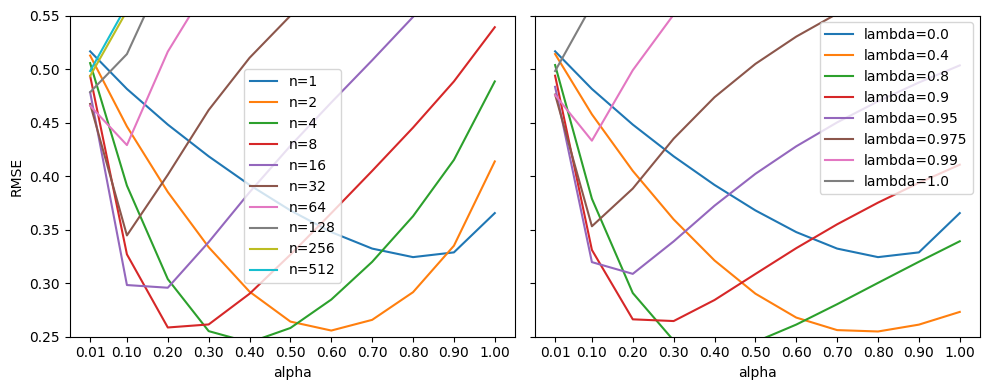

In [24]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

axes[0].set_ylabel('RMSE')
axes[0].set_ylim([0.25, 0.55])
axes[0].set_xlabel('alpha')
axes[0].set_xticks(alphas)
for i, n in enumerate(ns):
    axes[0].plot(alphas, n_scores[i], label=f'n={n}')
axes[0].legend()

axes[1].set_ylim([0.25, 0.55])
axes[1].set_xlabel('alpha')
axes[1].set_xticks(alphas)
for i, lmbda in enumerate(lambdas):
    axes[1].plot(alphas, lambda_scores[i], label=f'lambda={lmbda}')
axes[1].legend()

fig.tight_layout();